In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import prim, feature_scoring, dimensional_stacking
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from scipy.stats import pearsonr

from problem_formulation import get_model_for_problem_formulation
from plotting_function import customize_save_and_show_plot

current_dir = os.getcwd()  # Get current working directory
experiment_dir = os.path.join(current_dir, 'data', 'plots', 'Step1')
print(experiment_dir)
os.makedirs(experiment_dir, exist_ok=True)  # Create the directory if it doesn't exist

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1


# Step 1: Open Exploration

## Introduction

This notebook, prepared by analysts for Water Board 1 in Overijssel, provides an open exploration and sensitivity analysis of simulation outputs related to dike modeling. The primary objective is to evaluate the impacts of different policies and scenarios on various outcomes of interest to Water Board 1. The analysis utilizes data generated through three distinct sampling methods: random policy and scenario sampling, random scenario sampling without policy sampling, and Sobol sensitivity sampling. These experiments and their corresponding outcomes were generated using the script `Step1_Simulate_Open_Exploration.py`.

In their initial project description, Water Board 1 outlined three main goals: minimize expected annual damages, minimize dike investment costs, and keep the expected number of deaths to zero. This chapter primarily involves exploratory analysis to understand the underlying dynamics of the river model and will therefore not directly assess the feasibility of achieving these goals under different scenarios.

As mentioned above, to thoroughly explore and understand the simulation data, we utilized three distinct sampling methods. The first method, random policy and scenario sampling, explores a broad range of policy (lever settings) and scenario (uncertainty settings) combinations. This method helps in understanding the potential outcomes and behaviors of the model under different random conditions. The second method, scenario sampling with unchanged policies, maintains the current policy while exploring various scenarios, which serves as a reference point for comparing the effects of different uncertainties when no new policy is implemented. The third method, Sobol sensitivity sampling, uses Sobol sampling to systematically determine the influence of uncertainties on the model outputs. This technique is essential for identifying the most impactful uncertainties and understanding their interactions.

### Notebook Structure
The notebook is structured to provide a clear and detailed analysis, which includes the following steps:

1. **Descriptives**
2. **Exploratory Analysis with No Policy**:
    2.1. **Pairplot of Outputs**: Visualize the relationships between different outcome variables using pairplots.
    2.3. **Feature Scoring**: Assess the importance of different features using feature scoring methods.
    2.3. **Dimensional Stacking**: Understand the multidimensional interactions between features and outcomes through dimensional stacking.
    2.4. **PRIM (Patient Rule Induction Method)**: Identify and analyze regions in the data that lead to certain outcomes using PRIM.
3. **Exploratory Analysis with Multiple Policies**:
    2.1. **Pairplot of Outputs**: Visualize the relationships between different outcome variables using pairplots.
    2.3. **Feature Scoring**: Assess the importance of different features using feature scoring methods.
    2.3. **Dimensional Stacking**: Understand the multidimensional interactions between features and outcomes through dimensional stacking.
    2.4. **PRIM (Patient Rule Induction Method)**: Identify and analyze regions in the data that lead to certain outcomes using PRIM.
4. **Sensitivity Analysis (Sobol)**:Conduct a Sobol sensitivity analysis to determine the influence of uncertainties on the model outputs. This analysis helps in understanding which uncertainties significantly impact the outcomes and their interactions.

By following these steps, we aim to provide Water Board 1 with a comprehensive understanding of the potential impacts of potential policies and scenarios on the outcomes of interest, thereby aiding in informed decision-making for dike management and flood risk mitigation.

## Loading CSVs (Simulation Outputs)

We start by loading the simulation output data from CSV files generated by the different sampling methods in `Step1_Simulate_Open_Exploration.py`.

In [2]:
# Specify directory where CSVs are located
input_dir = os.path.join('data', 'output_data')

# Load the saved CSV files into variables
random_experiments_df = pd.read_csv(os.path.join(input_dir, 'random_experiments.csv'))
random_outcomes_df = pd.read_csv(os.path.join(input_dir, 'random_outcomes.csv'))
sobol_experiments_df = pd.read_csv(os.path.join(input_dir, 'sobol_experiments.csv'))
sobol_outcomes_df = pd.read_csv(os.path.join(input_dir, 'sobol_outcomes.csv'))
no_policy_experiments_df = pd.read_csv(os.path.join(input_dir, 'no_policy_experiments.csv'))
no_policy_outcomes_df = pd.read_csv(os.path.join(input_dir, 'no_policy_outcomes.csv'))

To ensure that the DataFrames are clean and only contain relevant data, we drop unnecessary columns that were automatically created during the CSV saving process (we remove the 'Unnamed: 0' column). Additionally, we clean up the column names by replacing underscores with spaces to enhance readability and interpretability of the data. This prepares the data for further analysis in the subsequent steps.

In [3]:
# Drop the 'Unnamed: 0' column from each DataFrame
random_experiments_df = random_experiments_df.drop(columns='Unnamed: 0')
random_outcomes_df = random_outcomes_df.drop(columns='Unnamed: 0')
sobol_experiments_df = sobol_experiments_df.drop(columns='Unnamed: 0')
sobol_outcomes_df = sobol_outcomes_df.drop(columns='Unnamed: 0')
no_policy_experiments_df = no_policy_experiments_df.drop(columns='Unnamed: 0')
no_policy_outcomes_df = no_policy_outcomes_df.drop(columns='Unnamed: 0')

# Replace underscores in variable names with spaces in column names for outcome DataFrames
for dataframe in [random_outcomes_df, sobol_outcomes_df, no_policy_outcomes_df]:
    dataframe.columns = dataframe.columns.str.replace('_', ' ')

We inspect the data by printing the contents of the random experiments and outcomes DataFrames. This step helps us understand the structure and content of the data.

In [4]:
# Inspect the columns of the random outcomes DataFrame
print(random_outcomes_df.columns)

Index(['A.4 Expected Annual Damage', 'A.4 Dike Investment Costs',
       'A.4 Expected Number of Deaths', 'A.5 Expected Annual Damage',
       'A.5 Dike Investment Costs', 'A.5 Expected Number of Deaths',
       'Combined Expected Annual Damage', 'Combined Dike Investment Costs',
       'Combined Expected Number of Deaths', 'policy'],
      dtype='object')


In this step, we extract two subsets of columns from the outcome DataFrames for further analysis. For each sampling method (random, no policy, and Sobol), we create two sets of DataFrames: one containing combined outcomes (representing aggregated measures across all dikes of Water Board 1) and another containing separate outcomes for each dike (A.4 and A.5). These extracted DataFrames will facilitate focused analysis on different aspects of the simulation results.

In [5]:
# Split up outcomes DataFrames for better analysis later on
random_outcomes_combined = random_outcomes_df[['Combined Expected Annual Damage', 'Combined Dike Investment Costs',
       'Combined Expected Number of Deaths', 'policy']]
random_outcomes_separate = random_outcomes_df[['A.4 Expected Annual Damage', 'A.4 Dike Investment Costs',
       'A.4 Expected Number of Deaths', 'A.5 Expected Annual Damage',
       'A.5 Dike Investment Costs', 'A.5 Expected Number of Deaths', 'policy']]

no_policy_combined = no_policy_outcomes_df[['Combined Expected Annual Damage', 'Combined Dike Investment Costs',
       'Combined Expected Number of Deaths']]
no_policy_separate = no_policy_outcomes_df[['A.4 Expected Annual Damage', 'A.4 Dike Investment Costs',
       'A.4 Expected Number of Deaths', 'A.5 Expected Annual Damage',
       'A.5 Dike Investment Costs', 'A.5 Expected Number of Deaths']]

sobol_combined = sobol_outcomes_df[['Combined Expected Annual Damage', 'Combined Dike Investment Costs',
       'Combined Expected Number of Deaths']]
sobol_separate = sobol_outcomes_df[['A.4 Expected Annual Damage', 'A.4 Dike Investment Costs',
       'A.4 Expected Number of Deaths', 'A.5 Expected Annual Damage',
       'A.5 Dike Investment Costs', 'A.5 Expected Number of Deaths']]

# 1. Descriptives

This section provides an initial overview of the simulation data by summarizing the key characteristics of the data. This preliminary analysis helps us understand the distribution of outcomes under different policy and scenarios and sets the stage for more detailed exploration later in the notebook.

In this section, we focus on three primary outcome variables: 
- `Combined Expected Number of Deaths`
- `Combined Dike Investment Costs`
- `Combined Expected Annual Damage`

We use violin plots to visualize the distribution of these outcomes under two distinct policy scenarios: "No Policy" and "Random Policies". Violin plots provide a detailed view of the data distribution, highlighting the probability density of the data at different values. This allows us to compare the difference in potential outcomes between the use of the current base case policy, and a wide variety of other policies.

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1
Plot saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1\Violin Plot of Combined Expected Number of Deaths.png


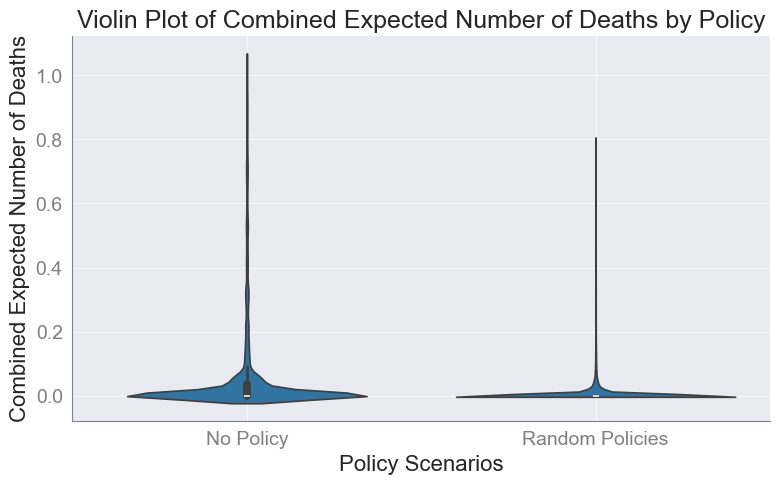

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1
Plot saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1\Violin Plot of Combined Dike Investment Costs.png


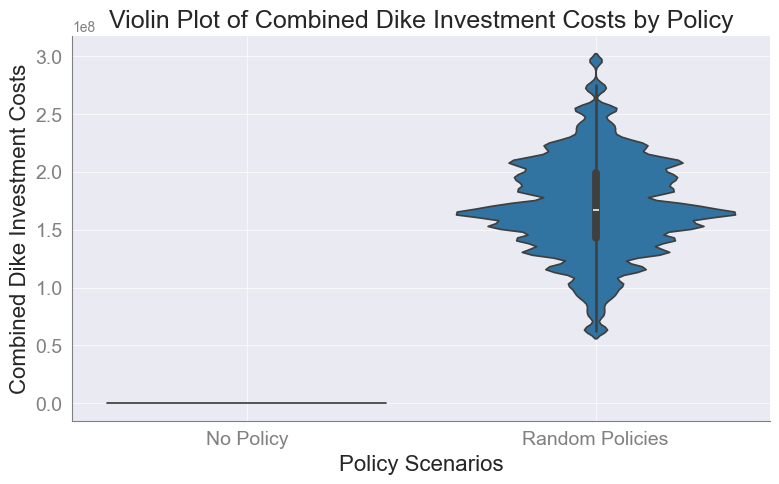

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1
Plot saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1\Violin Plot of Combined Expected Annual Damage.png


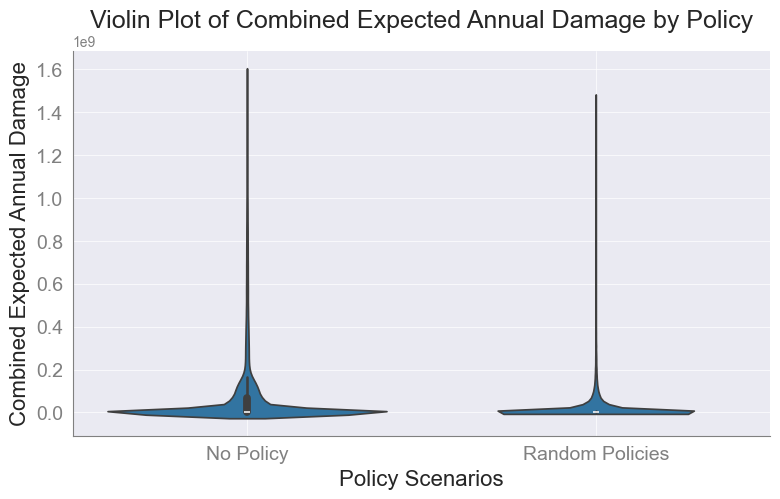

In [6]:
# Selecting the columns to plot
columns_to_plot = [
    'Combined Expected Number of Deaths',
    'Combined Dike Investment Costs',
    'Combined Expected Annual Damage'
]

# Combining the dataframes for the violin plot
combined_df = pd.concat([
    no_policy_outcomes_df[columns_to_plot].melt(var_name='Outcome', value_name='Value').assign(Policy='No Policy'),
    random_outcomes_df[columns_to_plot].melt(var_name='Outcome', value_name='Value').assign(Policy='Random Policies')
])

current_dir = os.getcwd()

# Plotting the violin plots for each outcome separately
for outcome in columns_to_plot:
    plt.figure(figsize=(9, 5))
    sns.violinplot(x='Policy', y='Value', data=combined_df[combined_df['Outcome'] == outcome])
    plt.title(f'Violin Plot of {outcome} by Policy')
    plt.xlabel('Policy Scenarios')
    plt.ylabel(outcome)
    customize_save_and_show_plot(f'Violin Plot of {outcome}', subfolder='Step1')
    plt.show()

Based on the three plots displayed above, several key observations can be made:

- **Dike Investment Costs**: The plot illustrating dike investment costs shows a wide range of cost variations, ranging from 0 to approximately 330 million. Notably, the distribution of costs appears to follow a normal distribution pattern. This distribution is expected given the high number of policy options and potential combinations explored, resulting in a diverse range of cost outcomes.
- **Expected Number of Deaths and Annual Damage**: In both the plots for expected number of deaths and annual damage, a consistent trend is observed. As policies are implemented, both the maximum number of deaths and damages decrease. Furthermore, the average annual damage decreased seven-fold, while the average number of deaths decreased twenty-fold when policy was implemented (see the descriptives displayed below), underlining the significant impact of policy implementation on mitigating deaths and reducing damages.

The cell below prints out the descriptives for both No Policy and Random Policy for all three variables of interest:

In [7]:
# Print descriptive statistics for `no_policy_outcomes_df`
print("Descriptive Statistics for no_policy_outcomes_df:")
print(no_policy_outcomes_df[columns_to_plot].describe())

# Print descriptive statistics for `random_outcomes_df`
print("\nDescriptive Statistics for random_outcomes_df:")
print(random_outcomes_df[columns_to_plot].describe())

Descriptive Statistics for no_policy_outcomes_df:
       Combined Expected Number of Deaths  Combined Dike Investment Costs  \
count                       500000.000000                        500000.0   
mean                             0.063663                             0.0   
std                              0.161127                             0.0   
min                              0.000000                             0.0   
25%                              0.000000                             0.0   
50%                              0.000000                             0.0   
75%                              0.036906                             0.0   
max                              1.045555                             0.0   

       Combined Expected Annual Damage  
count                     5.000000e+05  
mean                      7.981928e+07  
std                       1.867775e+08  
min                       0.000000e+00  
25%                       0.000000e+00  
50%       

# 2. Runs with No Policy

In this section, we delve into scenarios where no specific policies are implemented. Instead, we explore the uncertainty space by varying uncertainties within 500,000 different combinations. This comprehensive exploration enables us to grasp the model's behavior under various conditions without any policy interventions. Our analysis encompasses five key steps: visualizing the scenarios using a seaborn pairplot, feature scoring, dimensional stacking, PRIM, and sensitivity analysis.

We now set up a directory for saving the plots generated in section 2. We do this by creating a directory named "No Policy" within the `plots` folder. If the directory already exists, it ensures that it doesn't attempt to recreate it.

In [8]:
# Create directory for the plots we will make in this section
experiment_dir_no_policy = os.path.join(experiment_dir, 'No Policy')
print(experiment_dir_no_policy)
os.makedirs(experiment_dir_no_policy, exist_ok=True) 

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1\No Policy


## 2.1. Pairplot

We begin this step by creating a scatter plot to visualize the relationships between the outputs of interest in our dataset. Because policy is disabled the costs will always be zero. Therefore, we only plot the damages against the deaths to look at their relation. This visualization technique provides a clear understanding of the correlations or patterns between the outcomes, enabling us to identify potential dependencies or trends that may exist among them.

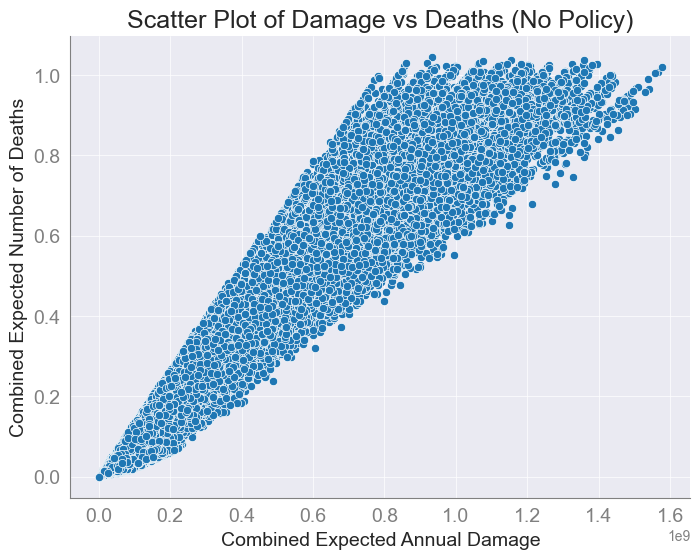

In [9]:
# Create scatter plot for two variables of interest
plt.figure(figsize=(8, 6))
sns.scatterplot(data=no_policy_combined, x='Combined Expected Annual Damage', y='Combined Expected Number of Deaths')

# Adding labels and title
plt.xlabel('Combined Expected Annual Damage')
plt.ylabel('Combined Expected Number of Deaths')
plt.title('Scatter Plot of Damage vs Deaths (No Policy)')

# Turning on grid lines to help in visualizing data points
plt.grid(True, which='both', linewidth=0.5)

# Making the border (spine) of the plot less prominent and gray
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(colors='gray', labelsize=14)
ax.yaxis.get_label().set_fontsize(14)
ax.xaxis.get_label().set_fontsize(14)

title = ax.title  # Get the title object
title.set_fontsize(18)  # Set the font size

# Saving the plot to the plot
plot_name = "scatterplot_damage_vs_deaths_no_policy"
plot_path = os.path.join(experiment_dir_no_policy, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

The scatter plot above illustrates the relationship between the number of deaths and the expected annual damage are quite strongly correlated, let us quicly print out the correlation scores for more clarification:

In [10]:
# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(no_policy_combined['Combined Expected Annual Damage'], no_policy_combined['Combined Expected Number of Deaths'])

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Correlation coefficient: 0.9819170122067215
P-value: 0.0


The correlation coefficient of 0.982 indicates a very strong positive correlation between the "Combined Expected Annual Damage" and "Combined Expected Number of Deaths" variables. This high correlation suggests that as one variable increases, the other variable tends to increase as well, and vice versa. In other words, when there are more expected deaths, there tends to be higher expected annual damage, and vice versa. This insight highlights the importance of considering both variables together when assessing the impact of various scenarios and policies on the system's outcomes.

## 2.2. Feature Scoring
Feature scoring in sensitivity analysis helps quantify the influence of model inputs (features) on outputs (such as deaths and damages in this case), aiding in understanding which features are most critical to model behavior. The scores are normalized to sum up to 1.0 across all features, providing a relative measure of importance rather than absolute impact.

In the following cell, we initialize the dike model according to the problem formulation. This step allows us to access and retrieve a list of uncertainties inherent to the model. Subsequently, we extract the values corresponding to these uncertainties from the simulations conducted for the `no_policy_experiments_df` DataFrame.

In [13]:
# Initialize the dike model from the problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(2)

# Access and print the uncertainties
dike_model_uncertainties = dike_model.uncertainties

# Create a list of uncertainty names
uncertainties = []

# Print out each uncertainty in the list
for uncertainty in dike_model_uncertainties:
    uncertainties.append(uncertainty.name)
    
no_policy_experiments_uncertainties = no_policy_experiments_df.loc[:,uncertainties]

print(no_policy_experiments_uncertainties)  

        discount rate 0  discount rate 1  discount rate 2  \
0                   3.5              3.5              2.5   
1                   2.5              4.5              4.5   
2                   1.5              3.5              2.5   
3                   3.5              2.5              1.5   
4                   2.5              1.5              2.5   
...                 ...              ...              ...   
499995              2.5              3.5              3.5   
499996              2.5              4.5              1.5   
499997              4.5              3.5              3.5   
499998              1.5              1.5              2.5   
499999              4.5              1.5              2.5   

        A.0_ID flood wave shape    A.1_Bmax  A.1_pfail  A.1_Brate    A.2_Bmax  \
0                           131   86.302045   0.055221        1.0  130.333284   
1                            60  155.015308   0.731952       10.0   86.198796   
2                       

We now calculate the feature scores to evaluate the influence of different uncertainties on the outcomes of interest. These feature scores provide a quantitative measure of the impact of each uncertainty on the outcomes. The heatmap visualization helps us understand the relative importance of each uncertainty in influencing the outcomes.

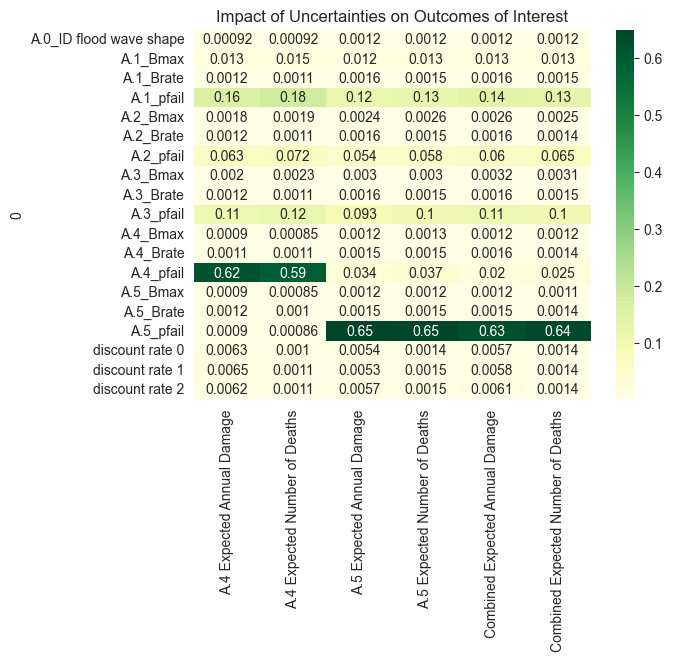

In [12]:
# Let us now calculate the feature scores for the different uncertainties, and their impact on the outcomes of interest
feature_scores = feature_scoring.get_feature_scores_all(no_policy_experiments_uncertainties, no_policy_outcomes_df.drop(columns=['A.4 Dike Investment Costs', 'A.5 Dike Investment Costs', 'Combined Dike Investment Costs', 'policy']))
sns.heatmap(feature_scores, cmap="YlGn", annot=True)
plt.title("Impact of Uncertainties on Outcomes of Interest")

# Saving the plot to the plot
plot_name = "feature_scores_no_policy"
plot_path = os.path.join(experiment_dir_no_policy, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

When applying feature scoring to the River Model, we assess the impact of various parameters on key performance metrics. This methodology reveals which features, such as flood wave shape, dike failure probability, discount rate, breach growth rate, and maximum breach width on outcomes like deaths and damages. For instance, higher scores for parameters related to flood protection infrastructure may indicate their critical role in mitigating flood damage or deaths.

When analyzing feature scores for dike rings A.4 and A.5 separately, A.4_pfail and A.5_pfail emerge as significant features with scores around 0.6, indicating substantial influence within their respective rings. However, when considering combined outcomes for deaths and damages across both rings, A.5_pfail shows greater dominance while A.4_pfails importance diminishes. This could be influenced by factors such as lower population density and fewer vulnerable structures in the area covered by A.4. Additionally, A.1_pfail, A.2_pfail, and A.3_pfail exhibit smaller impacts around 0.1 each, highlighting their lesser influence compared to A.5_pfail.

It's essential to interpret these scores carefully. While a high feature score suggests greater influence, it doesn't specify the direction of the relationship—whether increasing a parameter leads to positive or negative impacts on model outcomes. This ambiguity underscores the need for deeper analysis to uncover how changes in specific parameters interact with others across different scenarios.

## 2.3. Dimensional Stacking
Water Board 1 tasked us with minimizing deaths, damages, and investments while also identifying worst-case scenarios. These worst-case scenarios are those that result in the highest numbers of deaths and damages. Because investment levels are influenced primarily by policies rather than scenarios, we will in this section focus on analyzing deaths and damages.

To identify which combinations of uncertainties and levels of uncertainties (low, medium, high) are most likely to lead to worst-case scenarios, we will use dimensional stacking. This technique helps us visualize the interactions between multiple variables and their impact on specific outcomes. By creating a multidimensional pivot plot, we can see how different levels of uncertainties combine to produce adverse outcomes.

### 2.3.1 High Expected Annual Damage
We will first examine scenarios where the expected annual damage is among the highest 10 percent of all scenarios. The plot below will help identify critical scenarios in the base case (no policy) for attention and might help inform decision-making to mitigate these worst-case scenarios effectively.

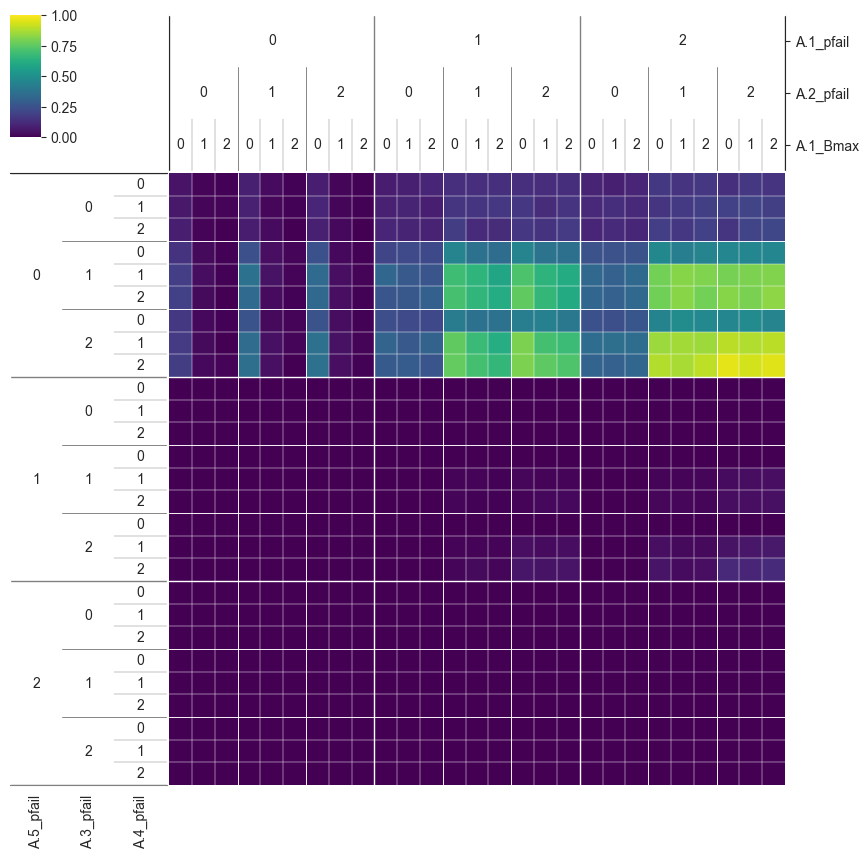

In [13]:
# Extract the uncertainty variables from the no policy experiments
x_no_policy = no_policy_experiments_uncertainties

# Identify scenarios where the combined expected annual damage is in the highest 10 percent
damage_no_policy = no_policy_outcomes_df['Combined Expected Annual Damage'].values > np.percentile(no_policy_outcomes_df['Combined Expected Annual Damage'], 90)

# Create a dimensional stacking plot to visualize the interaction of uncertainties leading to high damage
dimensional_stacking.create_pivot_plot(x_no_policy, damage_no_policy, nr_levels=3)

# Define the plot name and path to save the plot
plot_name = "dimensional_stacking_annual_damage_no_policy"
plot_path = os.path.join(experiment_dir_no_policy, f"{plot_name}.png")

# Save the plot to the specified path
plt.savefig(plot_path)

# Display the plot
plt.show()

#### Interpretation of Dimensional Stacking Results

In examining the worst-case scenarios for our actor above, we look at the top 10 percent of scenarios resulting in the highest damages. However, after also plotting the deaths as displayed above we realised that they looked almost exactly the same. However, based on the fact that there is a high and positive correlation (0.98) between deaths and damages, this explains the dimensional stacking plots almost look identical.

From our analyses, we can draw several key insights:

- **Dike Strength Impact**: If the dikes in Dike Rings 1, 2, and 3 are stronger (meaning their likelihood to fail is lower and their Pfail is higher), the chance for worst outcomes in Dike Rings 4 and 5 increases.
- **Weak Dike Ring 5**: If the Pfail for Dike Ring 5 is lower, indicating that the dike is not very strong, the probability of experiencing high damage and deaths also rises. Conversely, if the Pfail is medium to high (meaning it will fail medium to not at all), there are almost no incidents of high damage and deaths.
- **Worst-Case Scenarios**: The absolute worst-case scenarios, where 100% of the cases fall into the worst-case category, occur when the Pfail for Dike Rings 1 and 2 are high, while Dike Rings 4 and 5 have low Pfail simultaneously.

These findings highlight the critical impact of the strength and failure probabilities of various dike rings on the overall damage and death outcomes. It is essential to note that this analysis considers scenarios without any policy interventions.

**MAIN TAKE-AWAY**: For Water Board 1 it would be best to have a high Pfail (strong dikes), while the remaining Dike Rings 3, 4, and 5 have lower Pfails (weaker dikes). This would lead these other dike rings to flood and Water Board 1 (4 & 5) to remain unfloaded.

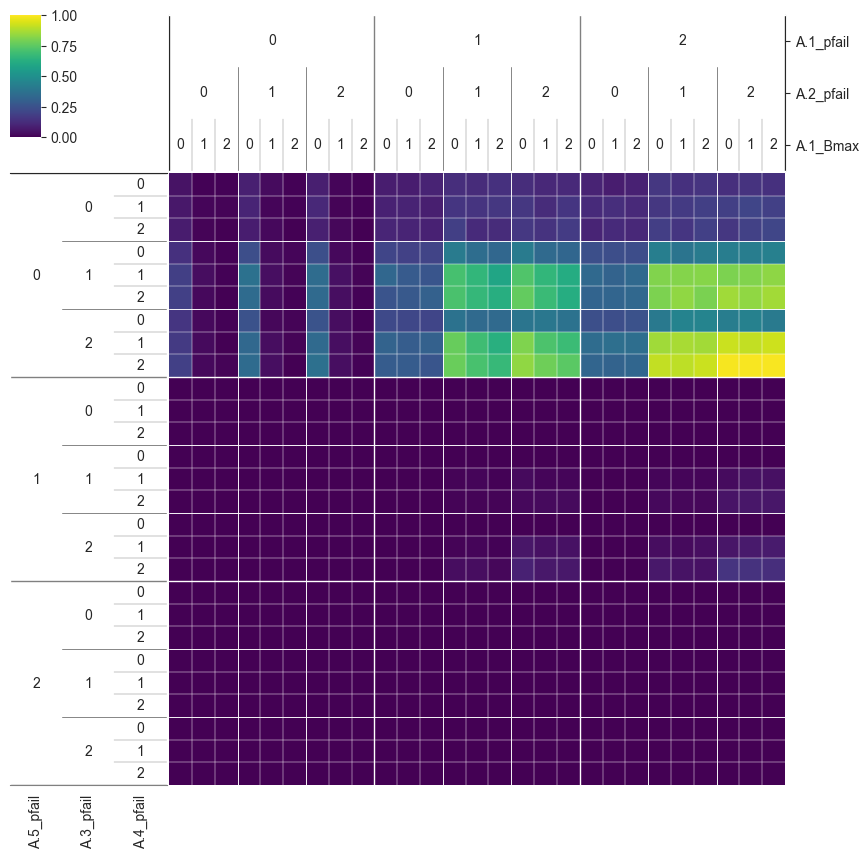

In [14]:
# Extract the uncertainty variables from the no policy experiments
x_no_policy = no_policy_experiments_uncertainties

# Identify scenarios where the combined expected number of deaths is in the highest 10 percent
deaths_no_policy = no_policy_outcomes_df['Combined Expected Number of Deaths'].values > np.percentile(no_policy_outcomes_df['Combined Expected Number of Deaths'],90)

# Create a dimensional stacking plot to visualize the interaction of uncertainties leading to high deaths
dimensional_stacking.create_pivot_plot(x_no_policy,deaths_no_policy, nr_levels=3)

# Define the plot name and path to save the plot
plot_name = "dimensional_stacking_deaths_no_policy"
plot_path = os.path.join(experiment_dir_no_policy, f"{plot_name}.png")

# Save the plot to the specified path
plt.savefig(plot_path)

# Display the plot
plt.show()

As explained and visible above deaths do the same as damages.

## 2.4. PRIM
In this section, we will utilize PRIM (Patient Rule Induction Method) to pinpoint specific regions in the data that contribute to particular outcomes. By focusing on worst-case scenarios, we aim to uncover which combinations of uncertainties are most critical in driving extreme outcomes. PRIM will be applied specifically to the top 10% worst outcomes of deaths and damages, allowing us to identify the distinct regions (or "boxes") in the uncertainty space that lead to these severe outcomes. This method provides a detailed understanding of the key features contributing to the worst-case scenarios, aiding in targeted strategies for mitigation and decision-making.

It is important to highlight that the same boxes are expected again, due to the extremely high correlation between deaths and damages in this model. Therefore, now the Expected Annual Damage PRIM will be executed and explained, however if the Deaths do the same they will not be discussed in the same depth.

The code below sets up the directory structure for storing PRIM analysis results within the directory dedicated to no-policy experiments. It ensures that the directory exists or creates it if it doesn't already.

In [15]:
# Define the directory path for PRIM results within the no policy experiments directory
experiment_dir_no_policy_PRIM = os.path.join(experiment_dir_no_policy, 'PRIM')
print(experiment_dir_no_policy_PRIM)

# Create the directory if it doesn't exist
os.makedirs(experiment_dir_no_policy_PRIM, exist_ok=True)

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1\No Policy\PRIM


### 2.4.1. Expected Annual Damage

In this section, we apply the PRIM (Patient Rule Induction Method) algorithm to the 10 percent highest expected annual damage. The threshold and peel_alpha parameters are adjusted to control the sensitivity of the algorithm in identifying significant regions.

In [16]:
# Apply PRIM to the 10% worst outcomes for the expected annual damage
prim_alg = prim.Prim(x_no_policy, damage_no_policy, threshold=0.8, peel_alpha=0.1)

# Find the most significant box (region) that leads to the highest expected annual damage
box1 = prim_alg.find_box()

Next, we visualize the results by displaying the tradeoff between coverage (the proportion of cases captured by the box) and density (the proportion of cases within the box that meet the criterion) for the identified boxes. This helps in understanding the tradeoffs involved in selecting different boxes.

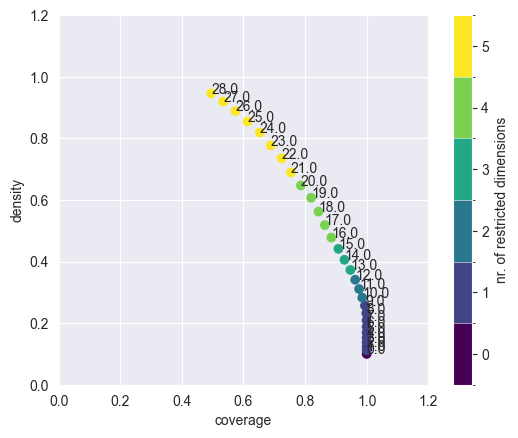

In [17]:
# Show the tradeoff plot for the created boxes
box1.show_tradeoff(annotated=True)

# Define the plot name and path to save the plot
plot_name = "tradeoff_damage_no_policy"
plot_path = os.path.join(experiment_dir_no_policy_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

# Display the plot
plt.show()

We will now select a box with a high coverage/density trade-off while also trying to minimize the number of dimensions (uncertainties). This is important because a smaller number of dimensions makes the outcomes more interpretable. Uncertainties are the variables that we do not control but which can influence the outcomes significantly.

Specifically, we will choose box 20, which has a coverage of 0.80 and a density of about 0.65.

- **Coverage (0.80)**: This means the box includes 80% of the worst-case scenarios identified in our dataset. A high coverage indicates that the box captures a significant portion of the extreme outcomes.
- **Density (0.65)**: This means that within the identified box, 65% of the cases are indeed worst-case scenarios. A higher density indicates that the box is accurate in identifying the worst cases with fewer false positives.

We will now inspect the selected box to understand the characteristics of the uncertainties within this region. This helps in identifying the critical combinations of uncertainties.

In [18]:
# Box X has been selected due to the +/- 80% density
box_number_of_choice = 20
box1.inspect(box_number_of_choice)[0]

coverage        0.786540
density         0.646996
id             20.000000
k           39327.000000
mass            0.121568
mean            0.646996
n           60784.000000
res_dim         4.000000
Name: 20, dtype: float64

             box 20                                  
                min       max       qp value qp value
A.5_pfail  0.000001  0.282468            NaN      0.0
A.1_pfail  0.343499  0.999999   0.000000e+00      NaN
A.3_pfail  0.272668  0.999999   0.000000e+00      NaN
A.2_pfail  0.099654  0.999999  2.142450e-170      NaN


Let's now create a graphical representation of the selected box to provide a clearer view of the significant uncertainties and their ranges.

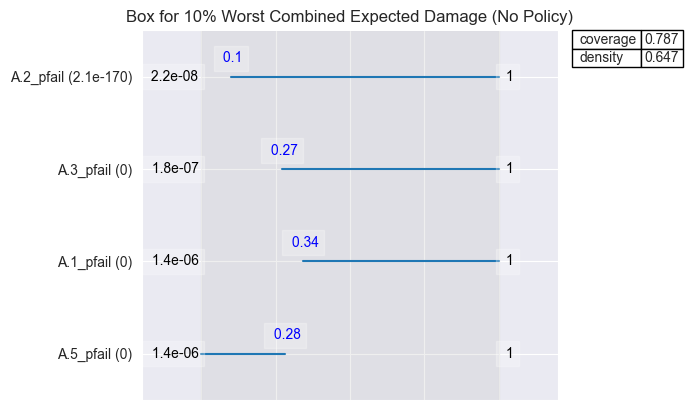

In [19]:
box1.inspect(box_number_of_choice, style="graph")

# Saving the plot to the plot
plt.title("Box for 10% Worst Combined Expected Damage (No Policy)")
plot_name = "inspect_box_damage_no_policy"
plot_path = os.path.join(experiment_dir_no_policy_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

As shown above, all the created boxes have very low p-values, indicating high statistical significance. This implies that the coverage (0.787) and density (0.647) are quite reliable. The ranges displayed in the plot represent the intervals within which 78.8 percent of the worst-case damages occur. Consistent with the dimensional stacking results, we find that medium to high failure probabilities in A1 and A3, combined with low failure probabilities in A5, lead to the worst-case damage outcomes. Regarding A2, we expected (based on the dimensional stacking) both low and high values to contain many of the bad cases, with low values containing some. This expectation is confirmed in the plot, where the range almost spans the entire possible range but ends at 0.1.

Below, we have created a plot showing the relationships between pairs of uncertainties within the selected box, helping to visualize the uncertainty values that lead to extreme outcomes. The orange dots represent the worst cases for damage, while the blue dots represent cases that are not in the worst 10%.

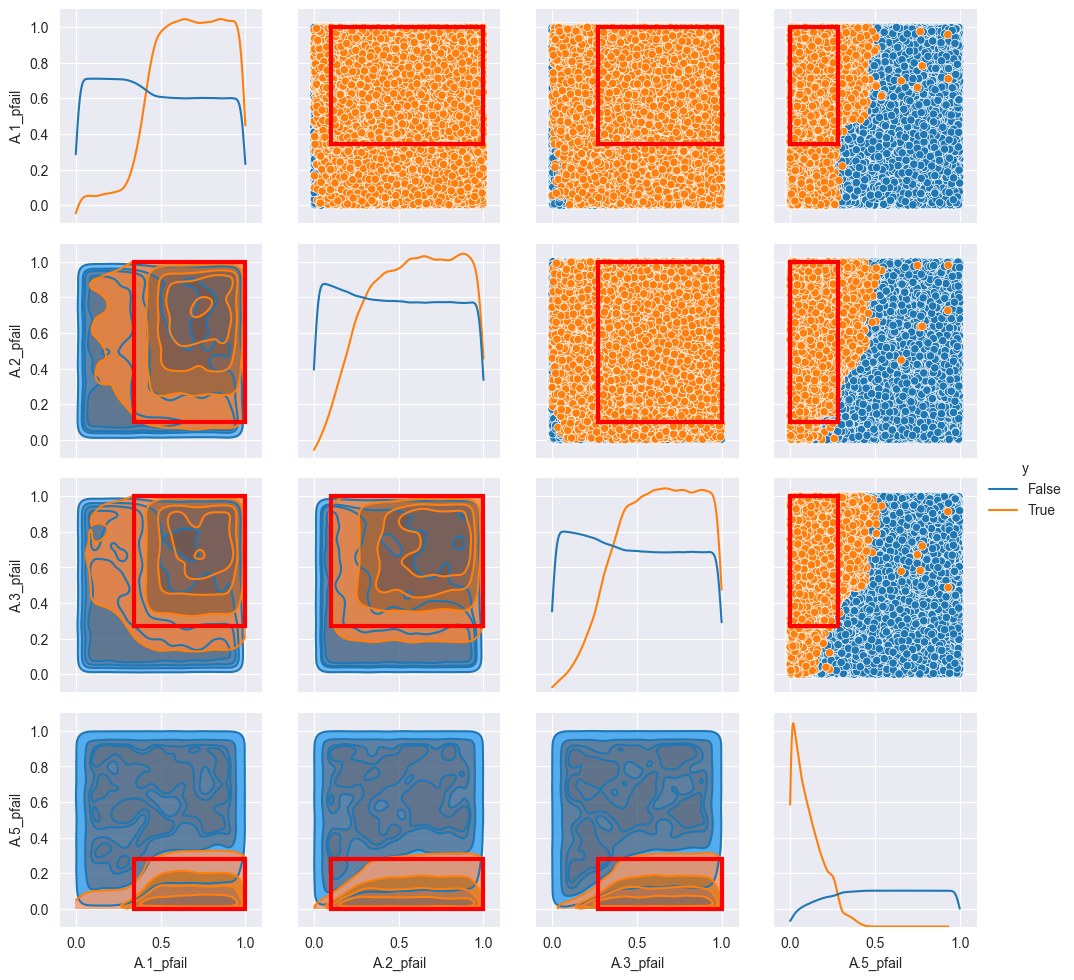

In [20]:
box1.show_pairs_scatter(box_number_of_choice)

# Saving the plot to the plot
plot_name = "box_scatter_damage_no_policy"
plot_path = os.path.join(experiment_dir_no_policy_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

#### Let us resample
This step verifies the robustness of the selected box by resampling and checking if the coverage and density remain consistent. High reproducibility indicates that the identified region is reliable.

As visible in the outputted table, the reproducibility of coverage and density is very high (both at 100%). This means that the selected box consistently captures the specified percentage of worst-case damages across multiple resampling iterations. Consequently, the identified region can be considered robust and reliable for our analysis.

In [21]:
box1.resample(box_number_of_choice)

,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
A.3_pfail,100.0,100.0
A.5_pfail,100.0,100.0
discount rate 0,0.0,0.0
discount rate 1,0.0,0.0
discount rate 2,0.0,0.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0


### 2.4.2. Expected Annual Deaths
The outcomes for deaths are similar to those for damages, which can be explained by the 0.98 correlation between the two variables. Consequently, we will not repeat the discussion for each code cell and outcome in this section.

In [22]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_no_policy, deaths_no_policy, threshold=0.8, peel_alpha= 0.1)
box2 = prim_alg.find_box()

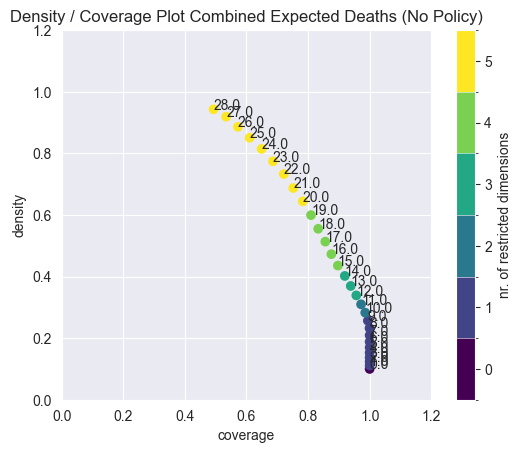

In [23]:
# Let's show the created boxes
box2.show_tradeoff(annotated=True)
plt.title("Density / Coverage Plot Combined Expected Deaths (No Policy)")

# Saving the plot to the plot
plot_name = "tradeoff_deaths_no_policy"
plot_path = os.path.join(experiment_dir_no_policy_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

This time we will choose box 19, as this one has the best trade-off between density and coverage.

In [24]:
# Box 19 has been selected due to the +/- 80% density
box2_number_of_choice = 19
box2.inspect(box2_number_of_choice)[0]

coverage        0.809640
density         0.599396
id             19.000000
k           40482.000000
mass            0.135076
mean            0.599396
n           67538.000000
res_dim         4.000000
Name: 19, dtype: float64

             box 19                                  
                min       max       qp value qp value
A.5_pfail  0.000001  0.282668            NaN      0.0
A.1_pfail  0.343721  0.999999   0.000000e+00      NaN
A.3_pfail  0.188864  0.999999   0.000000e+00      NaN
A.2_pfail  0.099816  0.999999  1.169945e-158      NaN


The boxes displayed below are almost identical to those for damages.

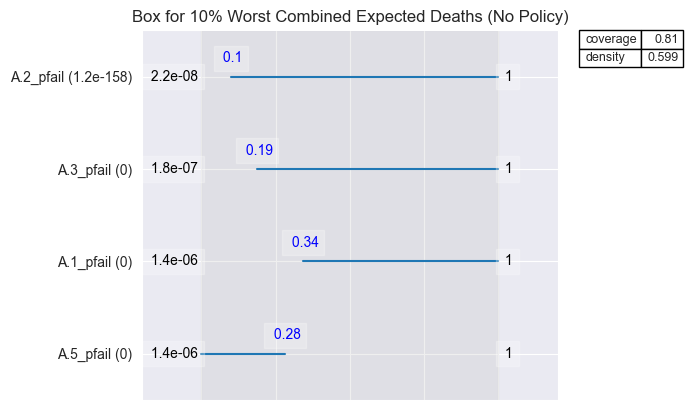

In [25]:
box2.inspect(box2_number_of_choice, style="graph")
plt.title("Box for 10% Worst Combined Expected Deaths (No Policy)")

# Saving the plot to the plot
plot_name = "inspect_box_deaths_no_policy"
plot_path = os.path.join(experiment_dir_no_policy_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

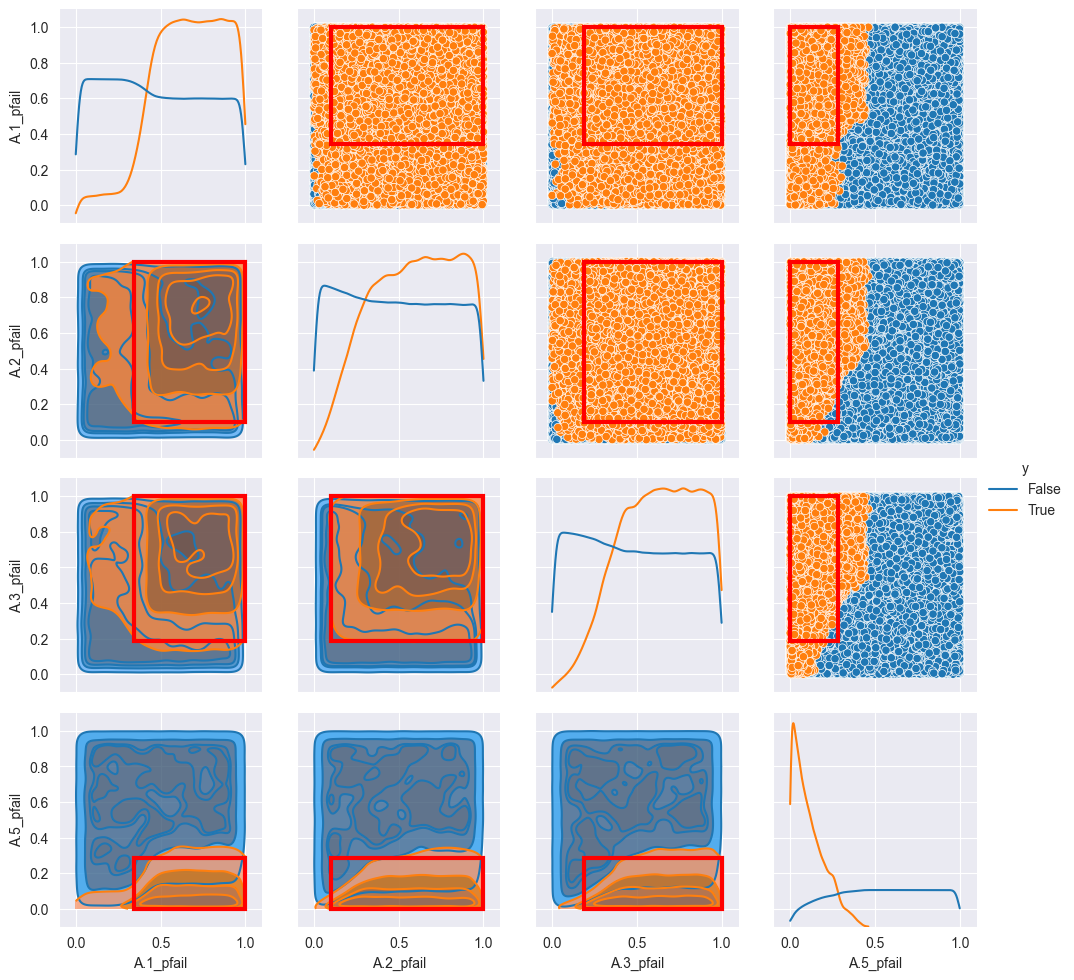

In [26]:
box2.show_pairs_scatter(box2_number_of_choice)

# Saving the plot to the plot
plot_name = "box_scatter_deaths_no_policy"
plot_path = os.path.join(experiment_dir_no_policy_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

#### Let us resample
The resampling again shows very high reproducibility

In [27]:
box2.resample(box2_number_of_choice)

,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
A.3_pfail,100.0,100.0
A.5_pfail,100.0,100.0
discount rate 0,0.0,0.0
discount rate 1,0.0,0.0
discount rate 2,0.0,0.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0


# 3. 200 Policy Runs

We will now look at 200 different policies under 2,000 different scenarios to create insight into 400,000 potential futures. We will again apply the five different methods that we used in step 2 above. Since the inherent goals of these methods have already been discussed, this section will focus on the outcomes of the analyses. Also, the code will not be as elaborately annotated.

Set up directory for 200 policies plots.

In [10]:
experiment_dir_200_policies = os.path.join(experiment_dir, '200 Policies')
os.makedirs(experiment_dir_200_policies, exist_ok=True)  

## 3.1. Pairplot
The pairplot displayed below shows the three different outcome variables in a pairplot. We have one dot per scenario/policy combination indication their damages, costs and investment. This plot is still quite hard to interpret. So we will continue with some metrics as well. 

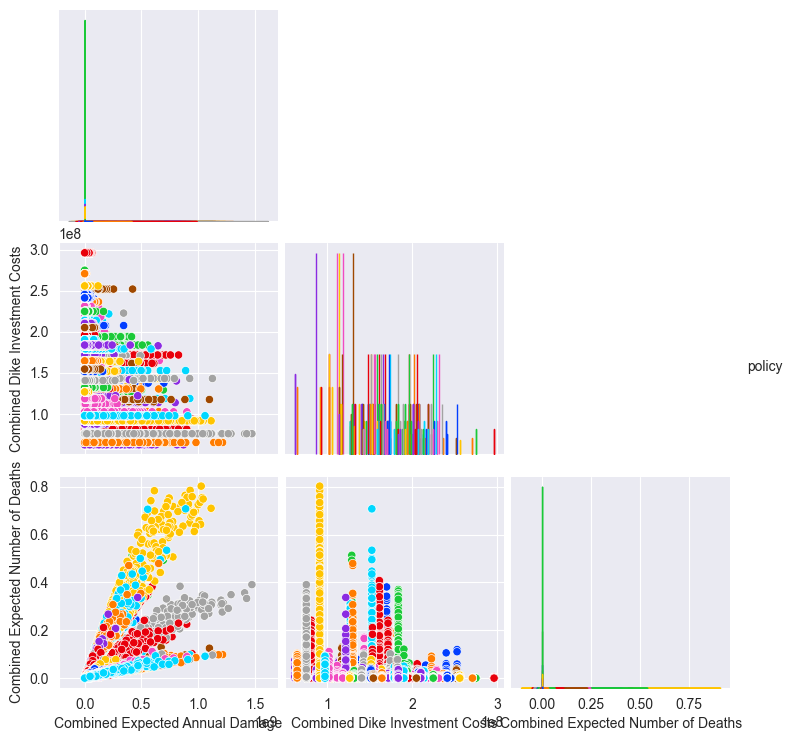

In [29]:
# Create multi scatter plot for 1,000 policies
sns.pairplot(random_outcomes_combined, hue='policy', plot_kws={'legend': None}, palette='bright', diag_kind='kde', corner=True)
plt.legend([], [], frameon=False)  # Hide the legend

plot_name = "pairplot_combined_outputs_200_policies"
plot_path = os.path.join(experiment_dir_200_policies, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

Let us now get the correlation and p-values for the correlations between the different outcomes of interest.

In [11]:
# Calculate the correlation coefficients and p-values
correlation_deaths_damage, p_value_deaths_damage = pearsonr(random_outcomes_combined['Combined Expected Annual Damage'],
    random_outcomes_combined['Combined Expected Number of Deaths']
)
correlation_damage_investment, p_value_damage_investment = pearsonr(random_outcomes_combined['Combined Expected Annual Damage'],
    random_outcomes_combined['Combined Dike Investment Costs']
)
correlation_deaths_investment, p_value_deaths_investment = pearsonr(
    random_outcomes_combined['Combined Expected Number of Deaths'],
    random_outcomes_combined['Combined Dike Investment Costs']
)

# Print the results
print(f"Correlation coefficient between damage and deaths: {correlation_deaths_damage:.4f} (p-value: {p_value_deaths_damage:.4e})")
print(f"Correlation coefficient between damage and investment: {correlation_damage_investment:.4f} (p-value: {p_value_damage_investment:.4e})")
print(f"Correlation coefficient between deaths and investment: {correlation_deaths_investment:.4f} (p-value: {p_value_deaths_investment:.4e})")

Correlation coefficient between damage and deaths: 0.7394 (p-value: 0.0000e+00)
Correlation coefficient between damage and investment: -0.2291 (p-value: 0.0000e+00)
Correlation coefficient between deaths and investment: -0.1537 (p-value: 0.0000e+00)


We again observe that deaths and damages are strongly positively correlated, with a correlation coefficient of 0.74, indicating a significant relationship. Although this correlation is slightly weaker than before, this was expected given that both scenarios and policies now influence the outcomes.

Regarding the correlations between investment and both damages and deaths, we find these relationships are also significant (p-values of 0) but notably weaker and negative, with correlation coefficients of -0.23 and -0.15, respectively. These negative correlations suggest that lower numbers of deaths or damages are generally associated with higher costs. 

This implies that reducing deaths and damages can typically be achieved through increased investments, meaning more or more expensive policy measures are implemented.

## 3.2. Feature Scoring
We again do feature scoring here, but first we get the uncertainty values.

In [14]:
random_experiments_uncertainties = random_experiments_df.loc[:,uncertainties]

print(random_experiments_uncertainties)

        discount rate 0  discount rate 1  discount rate 2  \
0                   2.5              2.5              3.5   
1                   2.5              4.5              1.5   
2                   1.5              4.5              4.5   
3                   1.5              1.5              1.5   
4                   4.5              3.5              3.5   
...                 ...              ...              ...   
399995              2.5              2.5              1.5   
399996              4.5              3.5              2.5   
399997              3.5              3.5              4.5   
399998              2.5              1.5              3.5   
399999              4.5              3.5              3.5   

        A.0_ID flood wave shape    A.1_Bmax  A.1_pfail  A.1_Brate    A.2_Bmax  \
0                             6  163.300431   0.691267        1.0  285.877885   
1                            88  231.917273   0.370773        1.5  326.256356   
2                       

Let us calculate the feature scores.

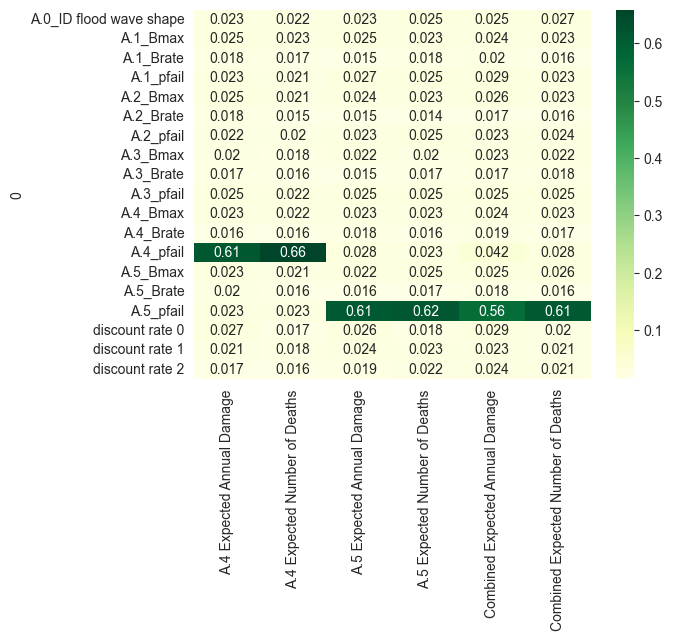

In [32]:
# Let us now calculate the feature scores for the different uncertainties, and their impact on the outcomes of interest
feature_scores = feature_scoring.get_feature_scores_all(random_experiments_uncertainties, random_outcomes_df.drop(columns=['A.4 Dike Investment Costs', 'A.5 Dike Investment Costs', 'Combined Dike Investment Costs', 'policy']))
sns.heatmap(feature_scores, cmap="YlGn", annot=True)

# Saving the plot to the plot
plot_name = "feature_scores_200_policies"
plot_path = os.path.join(experiment_dir_200_policies, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

As visible, this plot is almost identical to the previous one. However, there are a few notable observations:

- The difference between the feature scores for deaths and damages has increased. This was expected because their correlation has decreased, suggesting that these outcomes are likely influenced by certain uncertainties or policy levers.
- The impact of pfail scores for A1, A2, and A3 has decreased.
- It is also apparent that the overall feature scores have (and sum of feature scores has) become lower. This is probably due to the fact that uncertainties are no longer the only factors explaining the outcomes; the policy levers also exert part of the influence.

## 3.3. Dimensional Stacking
As visible in both dimensional stacking plots displayed below, it has become less clear when the worst cases occur. Previously, the worst scenarios were confined to a specific fraction of the uncertainty space, but now more squares contain fewer worst outcomes. However, it remains evident that weak dikes in dike ring 5 (low pfail) lead to most of the worst cases. Within this category, there is less variability and impact from other uncertainties visible.

Another observation is that weaker dikes in dike ring 4 also lead to worse outcomes, although this impact is less significant than that of dike ring 5. The influence of the probability of not failing of dike rings 1, 2, and 3 is no longer clearly distinguishable. This was expected, as their feature scores declined significantly (see the previous section). 

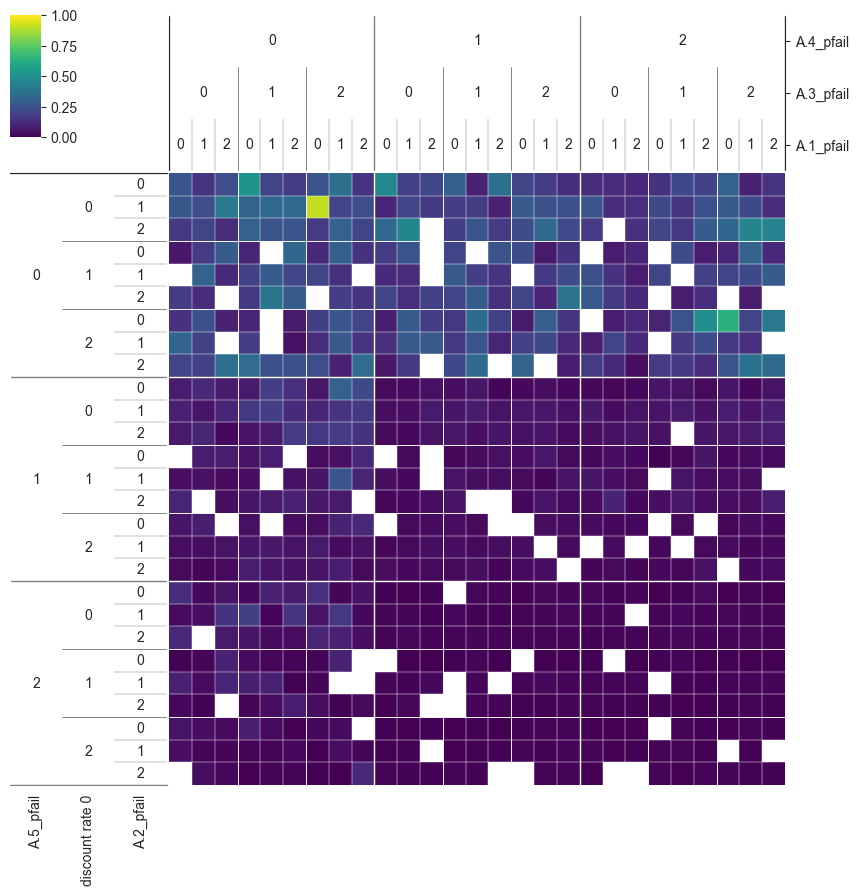

In [15]:
x_random_policy = random_experiments_uncertainties
damage_random_policy = random_outcomes_df['Combined Expected Annual Damage'].values > np.percentile(random_outcomes_df['Combined Expected Annual Damage'], 90)

dimensional_stacking.create_pivot_plot(x_random_policy,damage_random_policy, nr_levels=3)

# Saving the plot to the plot
plot_name = "dimensional_stacking_annual_damage_200_policies"
plot_path = os.path.join(experiment_dir_200_policies, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

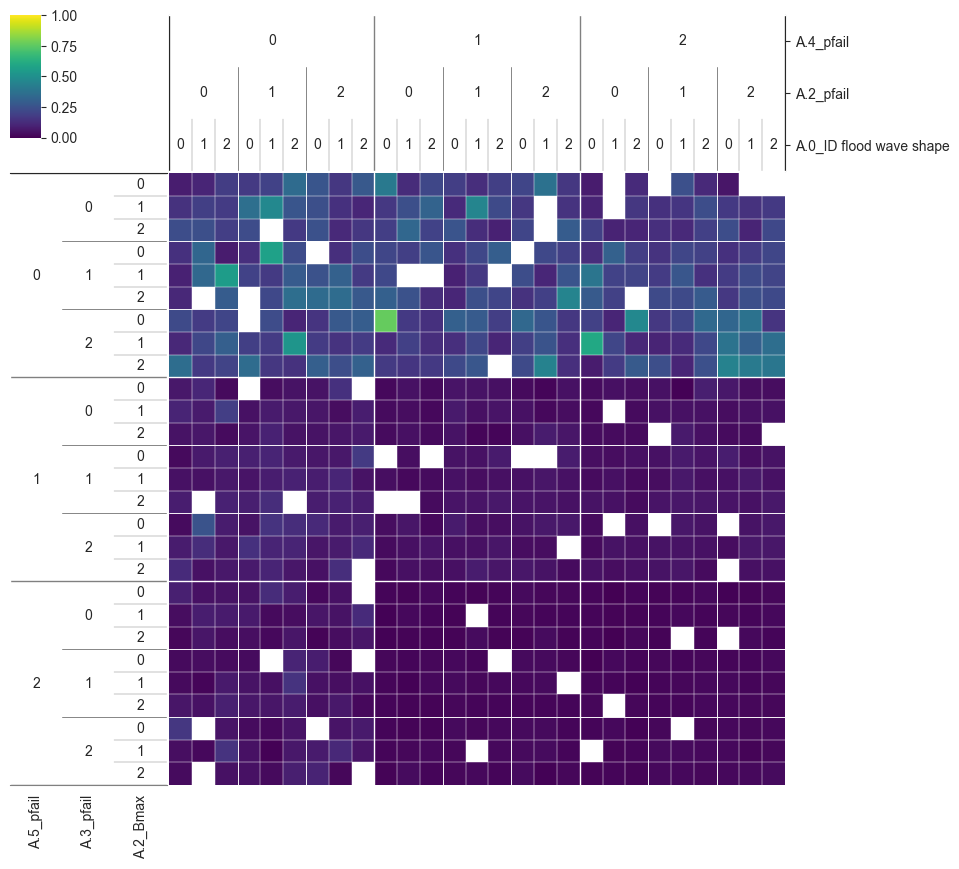

In [16]:
x_random_policy = random_experiments_uncertainties
deaths_random_policy = random_outcomes_df['Combined Expected Number of Deaths'].values > np.percentile(random_outcomes_df['Combined Expected Number of Deaths'], 90)

dimensional_stacking.create_pivot_plot(x_random_policy,deaths_random_policy, nr_levels=3)

# Saving the plot to the plot
plot_name = "dimensional_stacking_deaths_200_policies"
plot_path = os.path.join(experiment_dir_200_policies, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

## 3.4. PRIM
Set up directory for Prim results.

In [17]:
experiment_dir_200_policies_PRIM = os.path.join(experiment_dir_200_policies, 'PRIM')
print(experiment_dir_200_policies_PRIM)
os.makedirs(experiment_dir_200_policies_PRIM, exist_ok=True)  # Create the directory if it doesn't exist

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step1\200 Policies\PRIM


### 3.4.1. Expected Annual Damage

In [18]:
# applying PRIM to the 10% worst outcomes for the expected annual damage (highest damage costs)
prim_alg = prim.Prim(x_random_policy, damage_random_policy, threshold=0.45, peel_alpha= 0.1)
box3 = prim_alg.find_box()

As visible in the plot below, which displays the boxes attempting to capture the 10 percent worst cases of damages, the coverage/density trade-off has worsened. This means that the maximum density has significantly decreased alongside lower coverage values. The plot also shows that the box with the highest number of dimensions is only three, indicating that we can use a maximum of two variables to try to explain the worst outcomes.

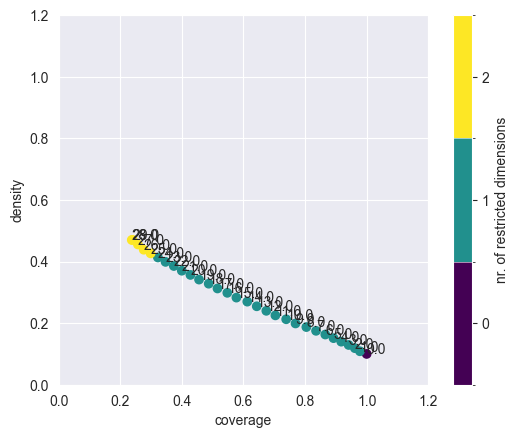

In [19]:
# Let's show the created boxes
box3.show_tradeoff(annotated=True)

plot_name = "tradeoff_damage_200_policies"
plot_path = os.path.join(experiment_dir_200_policies_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

We choose box 21.

In [20]:
box3_number_of_choice = 21
box3.inspect(box3_number_of_choice)[0]

coverage        0.399830
density         0.370139
id             21.000000
k           15990.000000
mass            0.108000
mean            0.370139
n           43200.000000
res_dim         1.000000
Name: 21, dtype: float64

             box 21                           
                min      max qp value qp value
A.5_pfail  0.000388  0.10805      NaN      0.0


As expected based on dimensional stacking, low values of pfail in dike ring 5 are again the best indicators of the worst cases for damages. However, their explanatory power remains limited, as they only cover 40% of the worst cases, and within these boxes, 63% of the outcomes are not among the 10 percent worst cases for damages.

**CONCLUSION: When policies are applied, it becomes very challenging to identify the combinations of uncertainties that lead to the worst-case damage outcomes.**

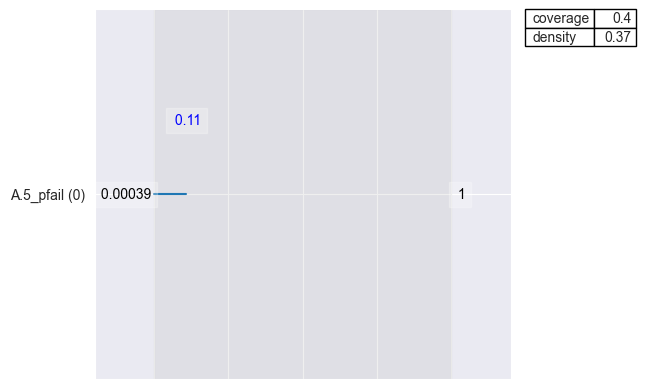

In [39]:
box3.inspect(box3_number_of_choice, style="graph")

plot_name = "inspect_box_damage_200_policies"
plot_path = os.path.join(experiment_dir_200_policies_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

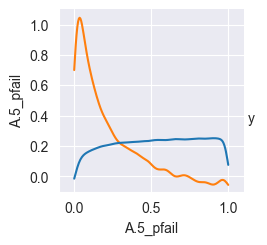

In [40]:
box3.show_pairs_scatter(box3_number_of_choice)

plot_name = "box_scatter_damage_200_policies"
plot_path = os.path.join(experiment_dir_200_policies_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

#### Let us resample
Reproducibility is high, but this does not really matter, as the outcomes are not that spectacular. And the outcome is that we can not predict.

In [41]:
box3.resample(box3_number_of_choice)

,reproduce coverage,reproduce density
A.5_pfail,100.0,100.0
discount rate 0,0.0,0.0
discount rate 1,0.0,0.0
discount rate 2,0.0,0.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_pfail,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_pfail,0.0,0.0


### 3.4.2. Expected Number of Deaths 

We will not discuss these separate plots. However, what we will say:

**CONCLUSION:When policies are applied, it becomes very challenging to identify the combinations of uncertainties that lead to the worst-case deaths outcomes.**


In [42]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_random_policy, deaths_random_policy, threshold=0.45, peel_alpha= 0.1)
box4 = prim_alg.find_box()

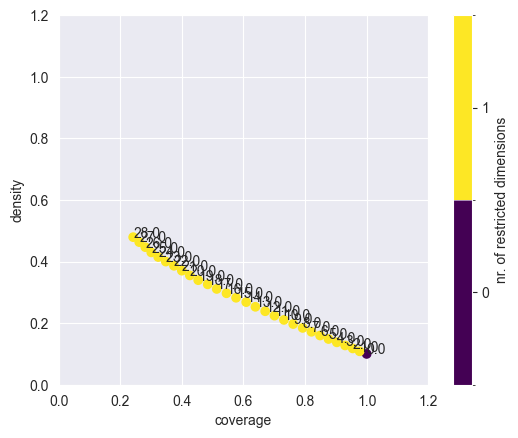

In [43]:
# Let's show the created boxes
box4.show_tradeoff(annotated=True)

plot_name = "tradeoff_deaths_200_policies"
plot_path = os.path.join(experiment_dir_200_policies_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

In [44]:
box4_number_of_choice = 20
box4.inspect(box_number_of_choice)[0]

coverage        0.425936
density         0.354938
id             20.000000
k           17037.000000
mass            0.120000
mean            0.354938
n           48000.000000
res_dim         1.000000
Name: 20, dtype: float64

             box 20                            
                min       max qp value qp value
A.5_pfail  0.000388  0.120139      NaN      0.0


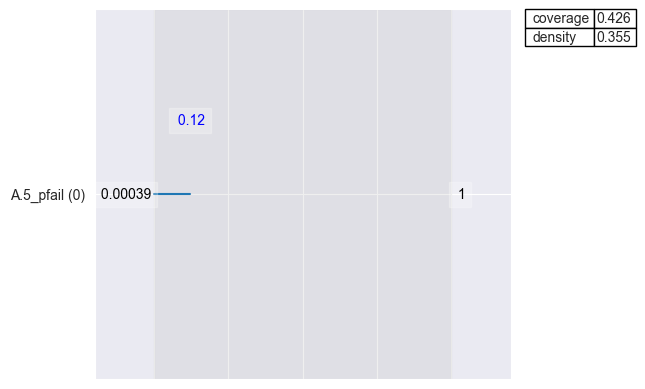

In [45]:
box4.inspect(box4_number_of_choice, style="graph")

plot_name = "inspect_box_deaths_200_policies"
plot_path = os.path.join(experiment_dir_200_policies_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

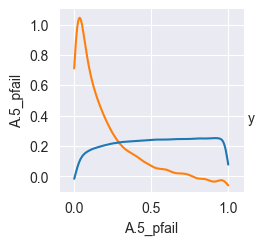

In [46]:
box4.show_pairs_scatter(box4_number_of_choice)

plot_name = "box_scatter_deaths_200_policies"
plot_path = os.path.join(experiment_dir_200_policies_PRIM, f"{plot_name}.png")
plt.savefig(plot_path)

plt.show()

#### Let us resample

In [47]:
box4.resample(box3_number_of_choice)

,reproduce coverage,reproduce density
A.5_pfail,100.0,100.0
discount rate 0,0.0,0.0
discount rate 1,0.0,0.0
discount rate 2,0.0,0.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_pfail,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_pfail,0.0,0.0


# 4. Sensitivity Analysis
In this section, we conduct a sensitivity analysis using the Sobol method. The Sobol sensitivity analysis is a global sensitivity analysis technique that quantifies the contribution of input variables to the variance in the output. This helps us understand which uncertainties have the most significant impact on the model outcomes. We will follow a systematic approach to perform this analysis and visualize the results.

Below we define the problem setup tobe able to extract relevant uncertainty data from a DataFrame of Sobol experiment results, and print the column names of the extracted data for verification. This process helps prepare and confirm the data required for the sensitivity analysis.

In [48]:
# Define the problem for the Sobol sensitivity analysis using the dike model uncertainties
problem = get_SALib_problem(dike_model.uncertainties)

# Extract uncertainties from the Sobol experiments DataFrame
sobol_experiments_uncertainties = sobol_experiments_df.loc[:,uncertainties]
print(sobol_experiments_uncertainties.columns)

Index(['discount rate 0', 'discount rate 1', 'discount rate 2',
       'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate',
       'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail',
       'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax',
       'A.5_pfail', 'A.5_Brate'],
      dtype='object')


This function, sobol_sensitivity_analysis, performs Sobol sensitivity analysis on a specified outcome variable and plots the results. It takes as inputs the name of the outcome variable (in this case Deaths or Damages), a DataFrame containing the outcomes of the Sobol sensitivity analysis, and a dictionary defining the problem for the SALib library. The function calculates sensitivity indices for the outcome variable, filters and organizes these indices, and then creates a bar plot to visualize them.

In [49]:
# Define a function to perform Sobol sensitivity analysis and plot the results for a specified outcome variable
def sobol_sensitivity_analysis(outcomes_variable, sobol_outcomes, problem_dict, outcome_type):
    """
    Perform Sobol sensitivity analysis for a specified outcome variable and plot the results.

    Parameters
    ----------
    outcomes_variable : str
        The name of the outcome variable to analyze.
    sobol_outcomes : pd.DataFrame
        DataFrame containing the outcomes from the Sobol sensitivity analysis.
    problem_dict : dict
        The problem definition for SALib.
    
    Returns
    -------
    Si : dict
        The Sobol sensitivity indices.
    """
    # Calculate mean and standard deviation for the specified outcome variable
    outcome_value = sobol_outcomes[outcomes_variable].values

    # Perform Sobol analysis
    Si = sobol.analyze(problem_dict, outcome_value, calc_second_order=True, print_to_console=True)

    # Filter Sobol indices to relevant metrics
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem_dict['names'])

    # Plot Sobol indices
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]

    indices.plot.bar(yerr=err.values.T, ax=ax)
    ax.set_ylabel('Sensitivity Index')
    ax.set_title(f'Sobol Sensitivity Analysis for {outcomes_variable}')
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(bottom=0.3)
    
    # Specify directory where CSVs are located
    save_dir = os.path.join(experiment_dir, 'Sobol Sensitivity')
    name = f"sobol_sensitivity_{outcome_type}"
    path = os.path.join(save_dir, f"{name}.png")
    plt.savefig(path)    
    
    plt.show()

    return Si

Now that we have set up the function, we can try to apply it to our two outcomes of interests; Damages and Deaths. We will now run both, and at the bottom we will explain what the outcomes show us.

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.021151  0.001562
A.1_Bmax                 0.034628  0.006948
A.1_Brate                0.000720  0.000235
A.1_pfail                0.267131  0.022580
A.2_Bmax                 0.007709  0.001990
A.2_Brate                0.000378  0.000113
A.2_pfail                0.140201  0.015057
A.3_Bmax                 0.008729  0.001736
A.3_Brate                0.000475  0.000174
A.3_pfail                0.212243  0.019010
A.4_Bmax                 0.000564  0.000209
A.4_Brate                0.000075  0.000041
A.4_pfail                0.070989  0.006679
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.856126  0.038383
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape -0.000857  0.002891
A.1_Bmax                 0.00546

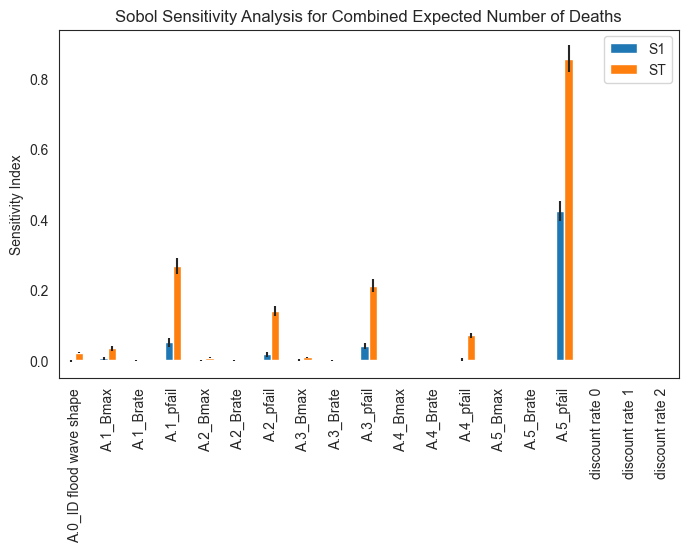

In [50]:
# Perform Sobol sensitivity analysis for the outcome variable 'Combined Expected Number of Deaths'
outcome_variable = 'Combined Expected Number of Deaths'
sobol_sensitivity_analysis(outcome_variable, sobol_outcomes_df, problem, outcome_type='deaths')

plt.show()

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.021053  0.002118
A.1_Bmax                 0.035988  0.005836
A.1_Brate                0.000780  0.000232
A.1_pfail                0.270854  0.022076
A.2_Bmax                 0.007566  0.001623
A.2_Brate                0.000388  0.000142
A.2_pfail                0.138279  0.013758
A.3_Bmax                 0.009299  0.002508
A.3_Brate                0.000458  0.000165
A.3_pfail                0.212076  0.019187
A.4_Bmax                 0.000582  0.000308
A.4_Brate                0.000067  0.000034
A.4_pfail                0.062706  0.006683
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.836142  0.032873
discount rate 0          0.008701  0.000750
discount rate 1          0.008698  0.000634
discount rate 2          0.008653  0.000751
                               S1   S1_conf
A.0_ID flood wave shape  0.000735  0.002581
A.1_Bmax                 0.00513

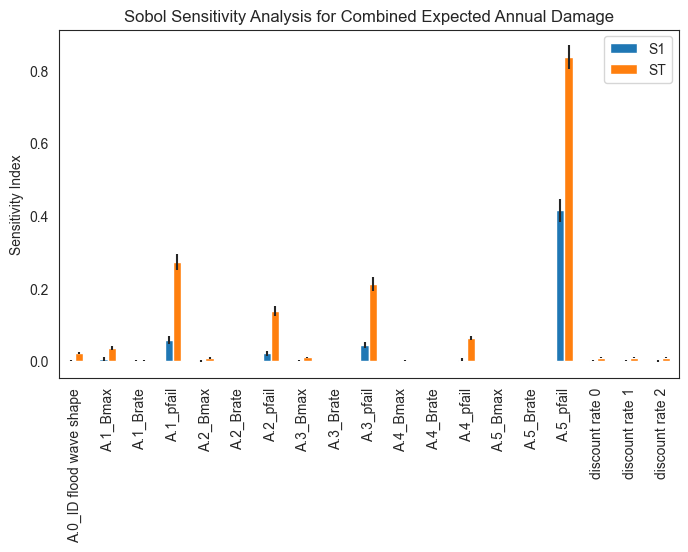

In [51]:
# Perform Sobol sensitivity analysis for the outcome variable 'Combined Expected Annual Damage'
outcome_variable = 'Combined Expected Annual Damage'
sobol_sensitivity_analysis(outcome_variable, sobol_outcomes_df, problem, outcome_type='damages')

plt.show()

The sensitivity plots for 'Combined Expected Annual Damage' and 'Combined Expected Number of Deaths' are nearly identical, which is expected given their high correlation of 0.74. Therefore, we will discuss them as if they are one and the same.

Let us discuss them in depth:

**First-Order Sensitivity Index (S1)**
- The probability of failure (pfail) for dike ring 5 has the highest impact on the outcome variables, with an S1 value of approximately 0.4. This means that it alone explains about 40% of the variation in the outcome variables.
- None of the other uncertainty variables have mentionable individual impacts on the outcomes, as indicated by their low S1 values (all below 0.05). This aligns with their low feature scores observed previously.

**Total-Order Sensitivity Index (ST)**
- The ST values show that five variables significantly impact the outcomes: the probability of failure for dike rings 1, 2, 3, 4, and 5.
- The probability of failure for dike ring 5 (pfail) explains about 80% of the variation in the outcome variables when considering both its direct and interaction effects.
- Dike ring 1’s pfail explains about 30% of the variation when interactions with other variables are considered.
- Dike ring 3’s pfail explains about 20% of the variation through its interactions.
- Dike ring 2’s pfail accounts for approximately 15% of the variation when combined with other variables.

**Consistency with Other Analyses**
- These results are consistent with the findings from dimensional stacking and PRIM (Patient Rule Induction Method). The probability of failure in dike ring 5 has the most significant impact on the outcomes, while the other dike rings have lesser but still notable effects.

**Conclusion**

The sensitivity analysis confirms that the probability of failure in dike ring 5 is the most critical scenario factor (non-policy) influencing both 'Combined Expected Annual Damage' and 'Combined Expected Number of Deaths'. Other dike rings contribute to the variation in outcomes primarily through their interactions with other variables, albeit to a lesser extent.

This analysis underscores the importance of focusing on reducing the probability of failure in dike ring 5 to mitigate both damages and deaths effectively.

# Summary of Results Open Exploration

This analysis has provided valuable insights into the impacts of uncertainties and policies on key outcomes for Water Board 1 in Overijssel.

From the descriptive analysis, we learned that implementing policies on average reduces expected annual damages and deaths. In the no policy scenario, we observed a strong positive correlation (0.982) between damages and deaths, with the failure probabilities of dike rings A.4 and A.5 being critical uncertainties. The worst outcomes were associated with weak dikes in Dike Rings 4 and 5.

In the analysis where we ran many policies under many scenarios, the correlation between damages and deaths was slightly weaker (0.74) due to the influence of policies, which also reduced the overall impact of uncertainties on outcomes.The worst outcomes in this case were associated with weak dikes in Dike Rings 5.

The Sobol sensitivity analysis confirmed that the failure probability of dike ring 5 is the most critical factor, explaining 80% of the variance in outcomes. Other dike rings contributed to the variance primarily through their interactions.

Overall, to effectively mitigate both damages and deaths, Water Board 1 should focus on reducing the failure probability of dike ring 5. This strategy addresses the primary source of variance in the outcomes and enhances overall flood risk management.